In [1]:
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from tqdm import tqdm
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor


sns.set(
    context="notebook",
    style="whitegrid",
    rc={"figure.dpi": 120, "scatter.edgecolors": "k"},
)


# Uebung 6 Boosting 

### Hilfsmethoden

In [2]:
cache = {}


def plot_decision_boundary(model, X, y):
    """Create a decision boundary plot that shows the predicted label for each point."""
    h = 0.05  # step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
    cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    k = model.min_samples_leaf
    if k in cache:
        Z = cache[k]
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        cache[k] = Z

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


def plot_decision_boundary_adaboost(classifier, X, y, N=1000, ax=None):
    """Utility function to plot decision boundary and scatter plot of data"""
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    # Initialize the sample weights
    sample_weight = np.ones(X.shape[0]) / X.shape[0]

    for i, zz in enumerate(
        classifier.staged_predict_proba(np.c_[xx.ravel(), yy.ravel()])
    ):
        plt.subplot(classifier.n_estimators, 2, 2 * i + 2)
        plt.title(f"Ensemble at Step {i + 1}")
        Z = zz[:, 1].reshape(xx.shape)
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        # Get current axis and plot
        ax = plt.gca()
        ax.contourf(xx, yy, Z, 2, cmap="RdBu", alpha=0.5)
        ax.contour(xx, yy, Z, 2, cmap="RdBu")
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
        ax.set_xlabel("$X_0$")
        ax.set_ylabel("$X_1$")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(classifier.n_estimators, 2, 2 * i + 1)
        plt.title(f"Decision Stump at Step {i + 1}")
        zz = classifier.estimators_[i].predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = zz[:, 1].reshape(xx.shape)

        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        # Get current axis and plot
        ax = plt.gca()
        ax.contourf(xx, yy, Z, 2, cmap="RdBu", alpha=0.5)
        ax.contour(xx, yy, Z, 2, cmap="RdBu")
        s_weights = (sample_weight / sample_weight.sum()) * 4000
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, s=s_weights)
        ax.set_xlabel("$X_0$")
        ax.set_ylabel("$X_1$")
        plt.xticks([])
        plt.yticks([])

        # Update samples weights
        y_pred = classifier.estimators_[i].predict(X)
        incorrect = y_pred != y
        estimator_weight = classifier.estimator_weights_[i]
        sample_weight *= np.exp(
            estimator_weight
            * incorrect
            * ((sample_weight > 0) | (estimator_weight < 0))
        )

    plt.tight_layout()
    plt.suptitle(
        "AdaBoost Decision Boundaries for\nDecision Stumps (left, scale indicates sample weight)\nand Ensemble (right) after each Iteration",
        x=0.5,
        y=1.05,
    )

# Run 10 fold cross-validation of the AdaBoost model
def evaluate(X: np.ndarray, y, learning_rate: np.ndarray):
    model = AdaBoostClassifier(n_estimators=300, learning_rate=learning_rate)
    scores = cross_validate(
        estimator=model,
        X=X,
        y=y,
        scoring="accuracy",
        cv=10,
        return_train_score=True,
        n_jobs=2,
    )
    return np.mean(scores["train_score"]), np.mean(scores["test_score"])


def plot_estimator_performance(accuracy_train, accuracy_test):
    plt.figure()
    plt.plot(accuracy_train, label="Train")
    plt.plot(accuracy_test, label="Test")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Accuracy")
    plt.title("AdaBoost Accuracy over Iterations")
    plt.legend()
    plt.show()



def visualize_gradient_boosting_sine(X, y, axs, staged_y_preds, i, step):
    # Plot sine curve fitting
    ax = axs[i//step]
    ax.set_xlim(0, X.max())
    ax.set_ylim(-1, 1)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$sin(x) / Prediction$")

    # Obtain lines
    error_lines = []
    for _ in range(X.shape[0]):
        (l,) = ax.plot([], [], c="red", alpha=0.4)
        error_lines.append(l)

    (line_true,) = ax.plot(X, y, lw=2)
    (line_pred,) = ax.plot([], [], lw=2)

    # Enable legend
    ax.legend(
        [line_true, line_pred, error_lines[0]],
        ["True", "Predicted", "Residuals"],
        loc="upper right",
    )

    # Animation function
    print(f"Progress: {i/len(staged_y_preds) * 100:.1f}%", end="\r")

    # Set error bars
    for j, err_l in enumerate(error_lines):
        err_l.set_data(
            [X[j], X[j]], [y[j], staged_y_preds[i][j]]
        )

    # Set prediction
    line_pred.set_data(X[:, 0], staged_y_preds[i])

    mse = mean_squared_error(y, staged_y_preds[i])
    ax.set_title(f"Iteration: {i}, MSE: {mse:.5f}", y=0.05)


def plot_sine(X, y):
    plt.figure()
    plt.plot(X, y)
    plt.xlabel("$x$")
    plt.ylabel("$sin(x)$")
    plt.title("Sinus Data")
    plt.show()


def plot_loss(errors):
    plt.figure()
    plt.plot(errors)
    plt.xlabel("Iteration")
    plt.ylabel("Least Squares Loss")
    plt.title("Gradient Boosting: Loss over Iterations")
    plt.show()


def annotate_axes_lr(ax):
    ax[0].set_title("Train")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("MSE")
    ax[1].set_title("Test")
    ax[1].set_xlabel("Iteration")
    plt.legend()
    plt.savefig("gradient_boosting_lr.pdf")
    plt.show()

def plot_decision_boundary_stump(stump: DecisionTreeClassifier, X: np.ndarray, y: np.ndarray, N=1000) -> None:
    """Plot the decision boundary for a tree stump and scatters plot of the training data"""
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    plt.figure(figsize=(4, 4))
    plt.title(f"Decision Boundary of a Decision Stump")
    zz = stump.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = zz[:, 1].reshape(xx.shape)
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    # Get current axis and plot
    ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap="RdBu", alpha=0.5)
    ax.contour(xx, yy, Z, 2, cmap="RdBu")
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    ax.set_xlabel("$X_0$")
    ax.set_ylabel("$X_1$")
    plt.tight_layout()


## Adaboost

### Daten Generierung

In [3]:
# Generate data
X, y = datasets.make_circles(noise=0.1, factor=0.4, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

### 1a) Datensatzvisualisierung

Beginnen wir mit einem künstlichen Datensatz, der aus zwei konzentrischen Kreisen besteht, die zwei Klassen
repräsentieren:
Visualisieren Sie den Datensatz in der Methode `plot_dataset`. Die Punkt der ersten und zweiten Klasse sollen dabei
farblich unterschieden werden und Trainings- und Testpunkte verschieden markiert werden.


In [44]:
def plot_dataset(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> None:
    """Creates as scatterplot for the given dataset. The points for the first class are blue and the points for the
     second class are red. Training points are displayed as dots and testpoints are described by an X."""
    
    plt.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, cmap=ListedColormap(["#FF0000", "#0000FF"]), label="Training Points", marker="o")
    plt.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, cmap=ListedColormap(["#FF0000", "#0000FF"]), label="Test Points", marker="x")

    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.legend()
    plt.show()
    

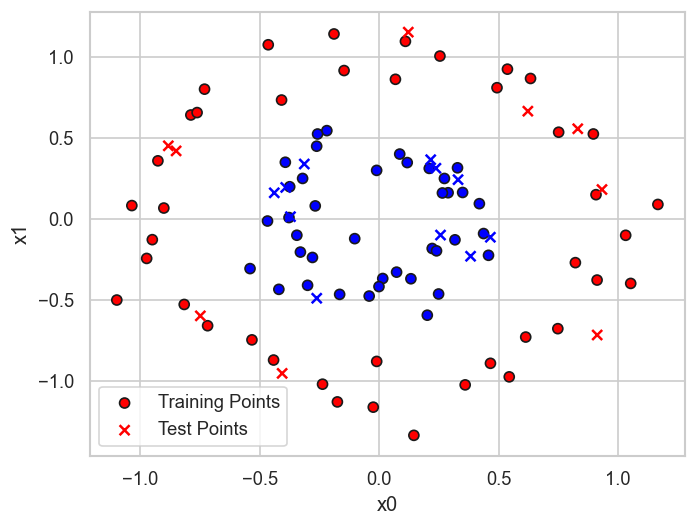

In [45]:
# Plot data
plot_dataset(X_train, X_test, y_train, y_test)

### 1b) Basislerner

Als Basislerner für das Boosting-Modell werden wir einen einfachen Entscheidungsbaum der Tiefe 1 (wegen seiner
visuellen Flachheit auch Entscheidungsstumpf genannt) wählen. Um ein Gefühl für dessen Einfachheit zu bekommen,
können wir den Stumpf auf die Daten selbst anpassen und die Entscheidungsgrenze visualisieren. Instanzieren Sie einen
`DecisionTreeClassifier` Stumpf und trainieren und visualiserien Sie die Entscheidungsgrenze des Stumpfes
mittels der vordefinierten Methode `plot_decision_boundary_stump`.

<Figure size 768x576 with 0 Axes>

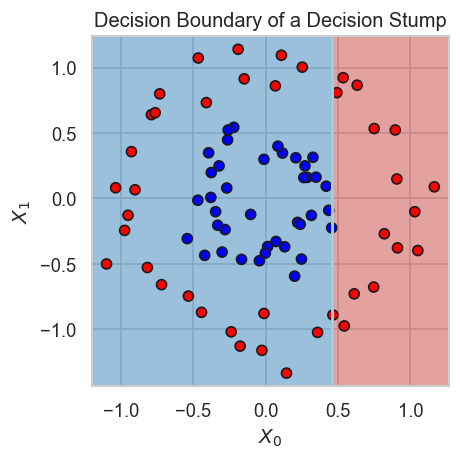

In [48]:
# Create Model
# FILL
strumpf = DecisionTreeClassifier(max_depth=1)
strumpf.fit(X=X_train, y=y_train)

# Plot the decision boundary
# FILL
plt.figure()
plot_decision_boundary_stump(stump=strumpf, X=X_train, y=y_train)
plt.show()

### Digits Datengenerierung und Visualierung

In [ ]:
def plot_digit_dataset(X_train: np.ndarray, y_train: np.ndarray) -> None:
    """Plots the first 5 images of the digit dataset."""
    plt.figure()
    for i, (x_i, y_i) in enumerate(zip(X_train[:5], y_train[:5]), start=1):
        plt.subplot(150 + i)
        plt.imshow(x_i.reshape(8, 8), cmap="gray")
        plt.title("label = " + str(y_i))
        plt.axis("off")
    plt.show()

# Load the digits dataset
X, y = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print("Digits shape:", X.shape)

# Plot samples
plot_digit_dataset(X_train, y_train)


### 2a) Iterationen / Anzahl Classifier

Wir werden das AdaBoost-Modell erneut mit einem Entscheidungsstumpf als Basis-Lerner für 300 Iterationen lernen.
Für jede Iteration wird ein zusätzlicher Entscheidungsstumpf eingesetzt.
Sklearn ermöglicht es uns über wiederholte Anwendung der Methode `staged_predict` auf einer Instanz des `AdaBoostClassifier`, stufenweise Vorhersagen zu treffen. Dies erzeugt Vorhersagen nach jeder Boosting-Iteration und erlaubt es uns, die
Genauigkeitskurve über die Trainingsiterationen zu visualisieren.
Fitten Sie ein `AdaBoostClassifier` über die Methode `get_acc_for_estimators` und geben Sie das Modell und
die zugehörigen Trainings- und Testgenauigkeiten für jede Iteration zurück.


In [ ]:
def get_acc_for_estimators(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray,
                           n_estimators: int, learning_rate: float) -> tuple[np.ndarray, np.ndarray]:
    """Fits an AdaBoostClassifier on the given training data and returns the training and test accuracy for all
     iterations."""
    # Create a Decision Tree with depth of 1 (stump) as weak base learner 
    # FILL
    # Create AdaBoost model
    # FILL
    # Fit model
    model.fit(X_train, y_train)
    # Evaluate model on train/test set using sklearn accuracy_score and staged_predict
    # FILL
    
    return accuracy_train, accuracy_test


In [ ]:
accuracy_train, accuracy_test = get_acc_for_estimators(X_train, X_test, y_train, y_test,
                                                        n_estimators=300, learning_rate=0.01)
plot_estimator_performance(accuracy_train, accuracy_test)

In [ ]:
lrs = [
    # FILL
       ]
# Plot
plt.figure()
# Run with specific learning rate
for lr in lrs:
  # FILL
 
  plt.plot(accuracy_train, label=f"$lr={lr}$")
plt.legend()
plt.suptitle("AdaBoost Learning Rate Comparison")
plt.xlabel("Number of Estimators")
plt.ylabel("Training Accuracy")
plt.show()

## Gradient Boosting

### 3b) Regression

Beginnen wir mit dem Lernen einer einfachen Sinuskurve.
Mit dem Modul GradientBoostingRegressor von sklearn können wir ein GradientBoosting-Regressionsmodell
an die erzeugte Sinuskurve anpassen. Wir werden die Residuen für insgesamt 300 Schritte anpassen und die Funktion
der kleinsten Quadrate als Fehlerfunktion verwenden.
Wenden Sie einen Gradient Boosting Regressor in der Funktion fit_gradient_boosting_regressor an und
geben Sie das gelernte Model und die Trainingsfehler für jede Iteration zurück




In [ ]:
def fit_gradient_boosting_regressor(X: np.ndarray, n_samples: int, y: np.ndarray,
                                    learning_rate: float, max_depth: int, random_state: int, loss: str):
    """Fits gradient tree boosting regressor and returns the learned model and training errors."""
    # create model and fit
    # FILL
    
    # Obtain loss after each training iteration
    # grab train_score_
    # FILL
    
    return gb, train_errors

In [ ]:
# data
# Create sine function
n_samples = 300
X = np.linspace(0, 4 * np.pi, num=n_samples).reshape(-1, 1)
y = np.sin(X[:, 0])

# Plot sine function
plot_sine(X, y)


In [ ]:
gb, errors = fit_gradient_boosting_regressor(X, n_samples, y, learning_rate=0.5, max_depth=1,
                                              random_state=0, loss="squared_error")

# Plot against iterations
plot_loss(errors)

In [ ]:
# Obtain staged predictions, that is the predictions of the ensemble after each step
staged_y_preds = [p for p in tqdm(gb.staged_predict(X))]

# Show boosting iterations
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 15), dpi=300)
axs = axs.flatten()
step = 50
for i in tqdm(range(0, n_samples, step)):
  visualize_gradient_boosting_sine(X, y, axs, staged_y_preds, i=i, step=step)
plt.show()

### 4a) Fehlerfunktionen
Evaluieren Sie die Performanz von Gradient Boosting in der Funktion evaluate_loss_fn unter Nutzung der
verschiedenen, oben genannten Fehlerfunktionen und geben Sie jeweils die mittleren Fehlerquadrate (MSE) für den
Trainings- und Testdatensatz zurück 

In [ ]:
def evaluate_loss_fn(X_train: np.ndarray, y_train: np.ndarray,
                     X_test: np.ndarray, y_test: np.ndarray,
                     loss_fn: str, learning_rate: float = 0.5, n_estimators: int = 200) -> np.ndarray:
    """Fits a GradientBoostingRegressor on the training data and returns the training and test mse for all iterations"""
    # create and fit model
    # FILL
   
    # Collect staged predict mean_squared_error for train/test
    mses = []
    # FILL
    
    return np.array(mses)

In [ ]:
# Load regression dataset
X, y = datasets.fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Set up plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].set_title("Train MSE")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MSE")
ax[1].set_title("Test MSE")
ax[1].set_xlabel("Iteration")

# Run on all available loss functions
for loss_fn in tqdm(["squared_error", "absolute_error", "huber", "quantile"]):
    mses = evaluate_loss_fn(X_train, y_train, X_test, y_test, loss_fn)
    ax[0].plot(mses[:, 0], label=loss_fn)
    ax[1].plot(mses[:, 1], label=loss_fn)

# Plot
plt.legend()
plt.show()